v9 latent_dim = 20 -> 200, dropout_rate = 0.4 -> 0.3
****
v12 n_epochs = 20 -> 225
***
v15 remove layers, image_size 128 -> 64, trainable_params 6e+6 -> 2e+6, n_epochs = 200 -> 50
***
v17 add batch normalization
***
v18 change data load method because ImageDataGenerator is suspected of malfunctioning

## Import modules

In [1]:
import os
import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam

## Configuration class

In [2]:
class Config:
    seed = 44
    n_epochs = 50
    batch_size = 32
    dropout_rate = 0.3
    latent_space_dim = 200
        
    validation_rate = 0.2
    
    image_size = 64
    channels = 3
    
    
    optimizer = Adam(lr=1e-4)
    
    reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                  mode='auto',
                                  factor=0.8,
                                  patience=2,
                                  epsilon=1e-4,
                                  coldown=5,
                                  min_lr=1e-5)
    
    checkpoint_best = ModelCheckpoint('best_model.h5',
                                      monitor='val_loss',
                                      mode='min',
                                      verbose=1,
                                      save_best_only=True,
                                      save_weights_only=False)
    
    checkpoint_last = ModelCheckpoint('last_model.h5',
                                      monitor='val_loss',
                                      mode='min',
                                      verbose=1,
                                      save_best_only=False,
                                      save_weights_only=False)
    
    early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=8)
    
    callbacks = [reduce_lr, checkpoint_best, checkpoint_last, early_stop]
    
    paths = {'images_folder': '/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba/',
             'list_attributes_file': '/kaggle/input/celeba-dataset/list_attr_celeba.csv'}

In [3]:
config = Config()

## Data load

In [4]:
def decode(path):
    img = file_bytes = tf.io.read_file(path)
    img = tf.image.decode_jpeg(file_bytes, channels=config.channels)  
    img = tf.image.resize(img, (config.image_size, config.image_size))
    img = tf.cast(img, tf.float32) / 255.0
    return img, img

In [5]:
def build_dataset(paths, shuffle=1, batch_size=1):
    AUTO = tf.data.experimental.AUTOTUNE
    
    dset = tf.data.Dataset.from_tensor_slices(paths)
    dset = dset.map(decode, num_parallel_calls=AUTO)
    
    dset = dset.shuffle(shuffle)
    dset = dset.batch(batch_size)
    return dset

In [6]:
image_paths = glob.glob(config.paths['images_folder'] + '*.jpg')

train_paths, valid_paths, _, _ = train_test_split(image_paths, image_paths, test_size=config.validation_rate, shuffle=True)

train_dataset = build_dataset(train_paths, batch_size=config.batch_size)
valid_dataset = build_dataset(valid_paths, batch_size=config.batch_size)

<Figure size 288x288 with 0 Axes>

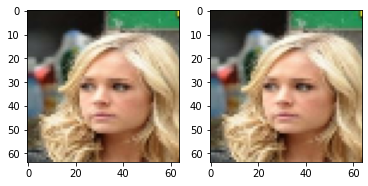

In [7]:
plt.figure(figsize=(4,4))
for n, (image, label) in enumerate(train_dataset.unbatch().take(1)):
    f, (ax1, ax2) = plt.subplots(1, 2) 
    
    ax1.imshow(image)
    ax2.imshow(label)
plt.show()


## Model architecture

In [8]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dropout, BatchNormalization, AveragePooling2D, MaxPooling2D
from tensorflow.keras.layers import Flatten, Dense, Lambda, UpSampling2D, Reshape

from tensorflow.keras.utils import plot_model
from tensorflow.keras.losses import mse, binary_crossentropy
from tensorflow.keras import backend as K

In [9]:
def sampling(args):
    """Reparameterization function by sampling from an isotropic unit Gaussian.
    # Arguments:
        args (tensor): mean and log of variance of Q(z|X)
    # Returns:
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [10]:
def VAE(input_shape=(config.image_size, config.image_size, config.channels)):
    
    #Encoder
    inputs = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(inputs)
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = BatchNormalization()(x)
    x = Dropout(config.dropout_rate)(x)
    
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = BatchNormalization()(x)
    x = Dropout(config.dropout_rate)(x)
    
    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = BatchNormalization()(x)
    x = Dropout(config.dropout_rate)(x)
    
    x = Flatten()(x)
    x = Dense(config.image_size, activation='relu')(x)
    
    latent_dim = config.latent_space_dim
    
    latent_mean = Dense(latent_dim, name='latent_mean')(x)
    latent_log_variance = Dense(latent_dim, name='latent_log_variance')(x)
    
    latent_sample = Lambda(sampling)([latent_mean, latent_log_variance])

    encoder = Model(inputs, [latent_mean, latent_log_variance, latent_sample])
    

    #Decoder
    latent_inputs = Input(shape=(latent_dim,))
    x = Dense(8 * 8 * config.image_size, activation='relu')(latent_inputs)
    x = Reshape((8, 8, config.image_size))(x)

    x = UpSampling2D((2, 2))(x)
    x = Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)

    outputs = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    decoder = Model(latent_inputs, outputs)
    
    outputs = decoder(encoder(inputs)[2])
    vae = Model(inputs, outputs)
    
    
    reconstruction_loss = K.sqrt(mse(inputs, outputs))
    reconstruction_loss = K.mean(reconstruction_loss) # mean at batch
    
    kl_loss = -0.5 * K.sum(1 + latent_log_variance - K.square(latent_mean) - K.exp(latent_log_variance), axis=-1)
    vae_loss = K.mean(reconstruction_loss + kl_loss) # mean at batch
    
    vae.add_metric(kl_loss, name="kl_loss")
    vae.add_metric(reconstruction_loss, name='reconst_loss')
    
    vae.add_loss(vae_loss)
    
    return vae, encoder, decoder

In [11]:

vae, encoder, decoder = VAE()
vae.compile(optimizer=config.optimizer)
    
vae.build(input_shape=(config.image_size, config.image_size, config.channels))
vae.summary()

ValueError: Please provide a TPU Name to connect to.

In [ ]:
plot_model(vae, to_file='vae.png', show_shapes = True, show_layer_names = True)

In [ ]:
plot_model(encoder,to_file='encoder.png', show_shapes = True, show_layer_names = True)

In [ ]:
plot_model(decoder, to_file='decoder.png', show_shapes = True, show_layer_names = True)

In [ ]:
if os.path.isfile("best_model.h5"):
    vae.load_weights('best_model.h5')

In [ ]:
vae.fit(train_dataset,
        epochs=config.n_epochs,
        #callbacks=config.callbacks,
        validation_data=valid_dataset)

In [ ]:
vae.load_weights('./best_model.h5')

## Reconstruction result

In [ ]:
data = list(valid_dataset.unbatch().take(20))

fig = plt.figure(figsize=(30, 10))
for n in range(0, 20, 2):
    image = vae.predict(np.expand_dims(data[n][0], axis=0))
    
    plt.subplot(2, 10, n + 1)
    plt.imshow(data[n][1])
    plt.title('original image')
    
    plt.subplot(2, 10, n + 2)
    plt.imshow(np.squeeze(image))
    plt.title('reconstruct')
    
plt.show()

## Generation new faces

In [ ]:
n_show_new_images = 30
random_codes = np.random.normal(size=(n_show_new_images, config.latent_space_dim))
new_faces = decoder.predict(np.array(random_codes))

fig = plt.figure(figsize=(30, 15))
fig.subplots_adjust(hspace=0.1, wspace=0.3)

for i in range(n_show_new_images):
    ax = fig.add_subplot(3, 10, i+1)
    ax.imshow(new_faces[i])
    ax.axis('off')
plt.show()